# Paraphrase Mining with SBERT
* Notebook by Adam Lang
* Date: 9/24/2024

# Overview
* in this notebook we will go over the following:
1. semantic textual similarity
2. clustering
3. paraphrase mining
4. asymmetric search
* all using SBERT transformers

## Imports

In [1]:
!pip install umap-learn

In [6]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 7.2 MB/s eta 0:00:00


In [2]:
## imports
import numpy as np
import pandas as pd

## data viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## dimensionality reduction
import umap

## widgets
import ipywidgets as widgets
import pprint

## time
import time
import datetime as dt
import os


In [3]:
## SBERT imports
from sentence_transformers import SentenceTransformer, util
import torch

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## tqdm
from tqdm import tqdm

## nltk
import nltk
nltk.download('punkt')
from nltk import tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
## transformers
import transformers

## Pre-trained SBERT
* Model hub: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [5]:
## MODEL IMPORT
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('')

# Semantic Textual Similarity - STS using SBERT

In [6]:
## import model
from sentence_transformers import SentenceTransformer, util
## model
model_sts = SentenceTransformer('paraphrase-MiniLM-L12-v2')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
## test sentences
sentences1 = ['The dog sits inside',
              'A boy is playing drums',
              'The new movie is awesome']

sentences2 = ['The cat plays in the yard',
              'A woman watches TV',
              'The new movie is amazing']


## compute sentence embeddings
embeddings1 = model_sts.encode(sentences1, convert_to_tensor=True)
embeddings2 = model_sts.encode(sentences2, convert_to_tensor=True)


## cosine similarity calculation
cosine_sim = util.pytorch_cos_sim(embeddings1, embeddings2)


## output pairs with cosine sim scores
for i in range(len(sentences1)):
  print("{} \t\t {} \t\t Cos Sim Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_sim[i][i]))

The dog sits inside 		 The cat plays in the yard 		 Cos Sim Score: 0.0129
A boy is playing drums 		 A woman watches TV 		 Cos Sim Score: -0.0092
The new movie is awesome 		 The new movie is amazing 		 Cos Sim Score: 0.9395


# Clustering with SBERT
* This will find groups of sentences that are highly similar in a large dataset.
* Threshold is adjustable
   * HIGH threshold --> very similar sentences
   * LOW threshod --> less similar sentences

* `min_community_size`: groups of sentences with at least a certan number of similar sentences returned.

In [8]:
## imports
from sentence_transformers import SentenceTransformer, util
import os
import csv
import time

## model for sbert embeddings --> specific for similar question detection
model_cluster = SentenceTransformer('paraphrase-MiniLM-L6-v2')


In [9]:
## get some data - Quora questions dataset
url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
dataset_path = 'quora_duplicate_questions.tsv'
max_corpus_size = 5000 ## limit corpus to first 5k questions

In [10]:
## check if dataset exits -- if not download and extract
if not os.path.exists(dataset_path):
  print("Downloading dataset....")
  util.http_get(url, dataset_path)

## get all unique sentences from file
corpus_sents = set()
with open(dataset_path, encoding='utf8') as fIn:
  reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
  for row in reader:
    corpus_sents.add(row['question1'])
    corpus_sents.add(row['question2'])
    if len(corpus_sents) >= max_corpus_size:
      break

## get corpus sents
corpus_sents = list(corpus_sents)
print("Encoding corpus....this may take a while.")

## create embeddings
corpus_embeddings = model_cluster.encode(corpus_sents, batch_size=64,
                                         show_progress_bar=True, convert_to_tensor=True)


## start clustering
print("Start clustering...")
start_time = time.time()

## 2 params to tune:
#min_cluster_size: only do this if have at least 25 elements
#threshold: consider sentence pairs with cosine sim larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=10,
                                    threshold=0.6)

## endclustering
print("Clustering done after {:.2f} sec".format(time.time() - start_time))



## print TOP 3 clusters and BOTTOM 3 elements
for i, cluster in enumerate(clusters):
  print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
  ## TOP 3 clusters
  for sentence_id in cluster[0:3]:
    print("\t", corpus_sents[sentence_id])
  print("\t", "...")
  ## BOTTOM 3 elements
  for sentence_id in cluster[-3:]:
    print("\t", corpus_sents[sentence_id])


Encoding corpus....this may take a while.


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Start clustering...
Clustering done after 1.61 sec

Cluster 1, #25 Elements 
	 How can I make money through the Internet?
	 How can I earn money on internet?
	 How do you earn money from internet?
	 ...
	 How can we earn money online in india?
	 How do I make money on an app?
	 How can I earn online with little investment?

Cluster 2, #23 Elements 
	 What should I do to improve my English ?
	 What can I do to improve my English speaking?
	 How can I continue to improve my English?
	 ...
	 What can I do to improve my English Grammar?
	 What is the best way to introduce yourself in English?
	 I am poor in English grammar so how should I improve my grammar?

Cluster 3, #23 Elements 
	 What do you think of abolishing 500 and 1000 Rupee Currency notes by the Indian Government?
	 What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?
	 What do you think about banning 500 and 1000 rupee notes in India?
	 ...
	 What will be the effect of banning 500 

In [11]:
## print TOP 3 clusters and BOTTOM 3 elements
for i, cluster in enumerate(clusters):
  print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
  ## TOP 3 clusters
  for sentence_id in cluster[0:3]:
    print("\t", corpus_sents[sentence_id])
  print("\t", "...")
  ## BOTTOM 3 elements
  for sentence_id in cluster[-3:]:
    print("\t", corpus_sents[sentence_id])


Cluster 1, #25 Elements 
	 How can I make money through the Internet?
	 How can I earn money on internet?
	 How do you earn money from internet?
	 ...
	 How can we earn money online in india?
	 How do I make money on an app?
	 How can I earn online with little investment?

Cluster 2, #23 Elements 
	 What should I do to improve my English ?
	 What can I do to improve my English speaking?
	 How can I continue to improve my English?
	 ...
	 What can I do to improve my English Grammar?
	 What is the best way to introduce yourself in English?
	 I am poor in English grammar so how should I improve my grammar?

Cluster 3, #23 Elements 
	 What do you think of abolishing 500 and 1000 Rupee Currency notes by the Indian Government?
	 What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?
	 What do you think about banning 500 and 1000 rupee notes in India?
	 ...
	 What will be the effect of banning 500 and 1000 notes on stock markets in India?
	 Is our 

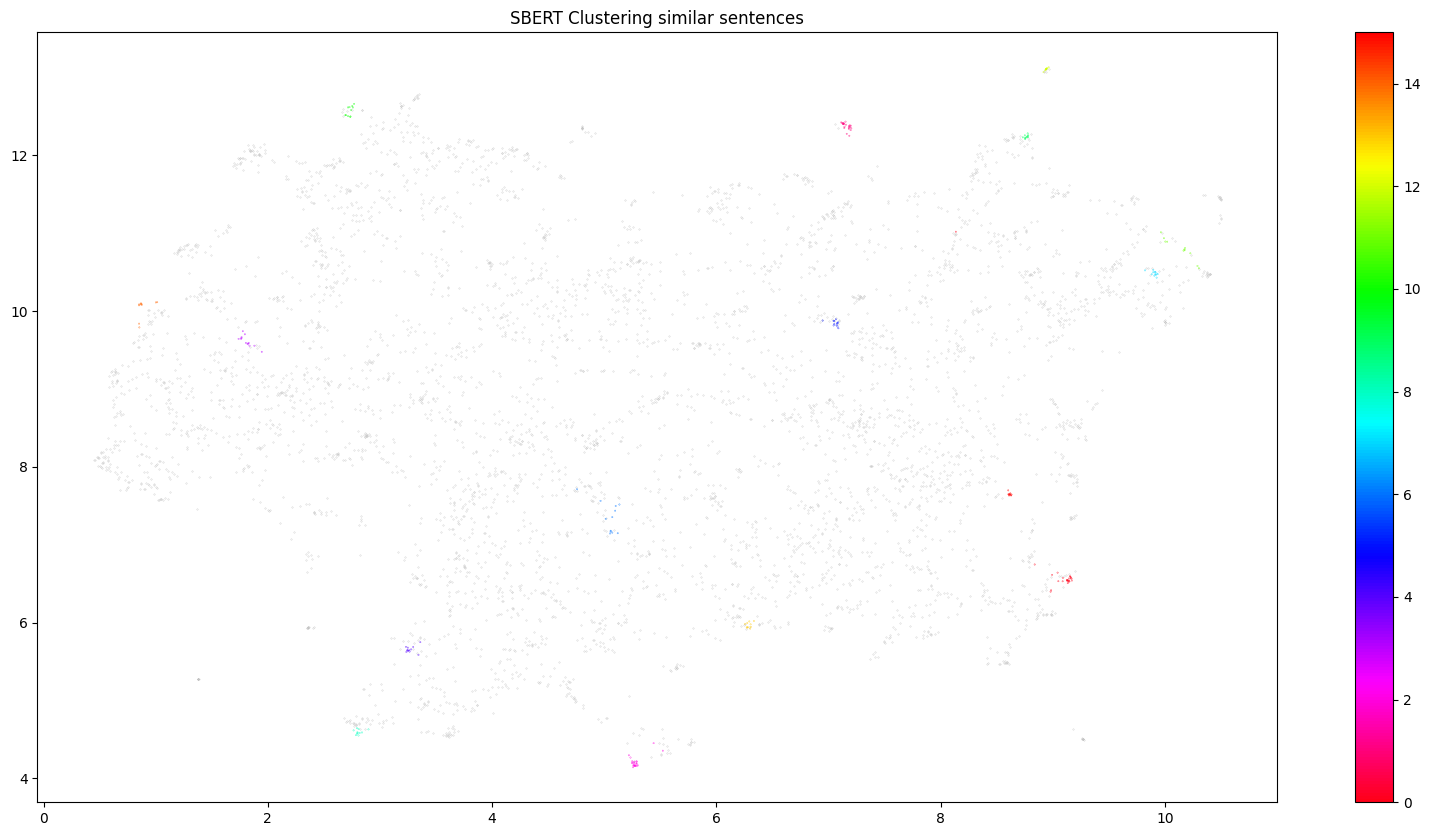

In [15]:
# Perform dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=2,
                            metric='cosine').fit_transform(corpus_embeddings)

# Visualize the clusters
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])

## flatten list of clusters and assign cluster labels to individual data points
cluster_labels = [cluster_id for cluster in clusters for cluster_id in cluster]

## create a list of labels the same length as the dataframe
labels = [-1] * len(corpus_embeddings)
for i, cluster in enumerate(clusters):
    for sentence_id in cluster:
        labels[sentence_id] = i

result['labels'] = labels # changed from clusters

## plot specifics
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.title('SBERT Clustering similar sentences')
plt.show();

# Paraphrase Mining with SBERT
* Paraphrase mining is the task of finding paraphrases (text with identical/similar meaning) in a large document or corpus of sentences.
* In semantic textual similarity, we saw a simplified version of finding paraphrases in a list of sentences.
  * This approach below is a **brute-force** approach to score and rank all pairs.
  * However, note that this has a quadratic runtime, it will fail to scale to `10,000` and larger collections of sentences with SBERT.
* Solution.....!!!
   * For larger sentence collections, util offers the `paraphrase_mining` function which is in the SBERT module.

Various pre-trained models on paraphrase datasets:
1. `paraphrase-MiniLM-L12-v2`
2. `paraphrase-distilroberta-base-v2`
3. `paraphrase-distilroberta-base-v1`
4. `paraphrase-xlm-r-multilingual-v1`
5. `paraphrase-mpnet-base-v2`
6. `paraphrase-multilingual-mpnet-base-v2`
7. `paraphrase-MiniLM-L6-v2`
...etc...there are 11 models

In [21]:
## implementing paraphrase mining function
from sentence_transformers import SentenceTransformer, util

## embedding model
model_para = SentenceTransformer('paraphrase-MiniLM-L6-v2')


## dummy data
para_sents = ['The cat sits outside',
              'A man is playing guitar',
              'I love pasta',
              'The new movie is awesome',
              'The cat plays in the garden',
              'A woman watches TV',
              'The new movie is so great',
              'Do you like pizza?']


## setup paraphrase mining
paraphrases = util.paraphrase_mining(model_para, para_sents, corpus_chunk_size=len(para_sents),
                                     top_k=1)


## print mined paraphrases
for paraphrase in paraphrases[0:10]:
  score, i, j = paraphrase
  print("{} \t\t {} \t\t Score: {:.4f}".format(para_sents[i], para_sents[j], score))


The new movie is awesome 		 The new movie is so great 		 Score: 0.9298
The cat sits outside 		 The cat plays in the garden 		 Score: 0.6497
I love pasta 		 Do you like pizza? 		 Score: 0.4269
The new movie is awesome 		 A woman watches TV 		 Score: 0.1318
A man is playing guitar 		 The cat plays in the garden 		 Score: 0.0924


In [24]:
## using a different model
from sentence_transformers import SentenceTransformer, util

## model para
model_para2 = SentenceTransformer('paraphrase-MiniLM-L12-v2')

## sentences
para_sents = para_sents ## same as above



## setup paraphrase mining
paraphrases2 = util.paraphrase_mining(model_para, para_sents, corpus_chunk_size=len(para_sents),
                                     top_k=2) ## top_k -> for each sentence retrieve top_k similar sents
                                              ## defaults to 100


## print mined paraphrases
for paraphrase in paraphrases2[0:10]:
  score, i, j = paraphrase
  print("{} \t\t {} \t\t Score: {:.4f}".format(para_sents[i], para_sents[j], score))


The new movie is awesome 		 The new movie is so great 		 Score: 0.9298
The cat sits outside 		 The cat plays in the garden 		 Score: 0.6497
I love pasta 		 Do you like pizza? 		 Score: 0.4269
I love pasta 		 The new movie is so great 		 Score: 0.2594
I love pasta 		 The new movie is awesome 		 Score: 0.2528
The new movie is awesome 		 Do you like pizza? 		 Score: 0.1423
The new movie is awesome 		 A woman watches TV 		 Score: 0.1318
A woman watches TV 		 Do you like pizza? 		 Score: 0.1185
A man is playing guitar 		 The cat plays in the garden 		 Score: 0.0924
The cat sits outside 		 Do you like pizza? 		 Score: 0.0826


Summary:
* If we change the `top_k` value it tries to match the cosine similarity based most similar sentences. We can see if the corpus is small this doesn't work well but could be useful for a larger document.

# Question-Answer Retrieval - MSMARCO
* The MSMARCO passage ranking is a dataset with 500k real queries from Bing search.
* Given a search query, this will find the relevant passages in the text.
* Models tuned for **cosine-similarity** will prefer the retrieval of **shorter passages**, while models for **dot-product** will prefer the retrieval of **longer passages**. Depending on your task, you might prefer the one or the other type of model.
* Full list of MSMARCO models: https://www.sbert.net/docs/pretrained-models/msmarco-v3.html

In [26]:
## implementation
from sentence_transformers import SentenceTransformer, util
model_msmarco = SentenceTransformer('msmarco-distilbert-base-v3')


##query and passage
query_emb = model_msmarco.encode('How big is Tokyo')
passage_emb = model_msmarco.encode('Tokyo has 37,115,000 people living there as of 2024.')

## similarity
print("Similarity:", util.pytorch_cos_sim(query_emb, passage_emb))

Similarity: tensor([[0.6042]])


# Question-Answer Retrieval - Natural Questions
* Google has models trained on a Natural Questions dataset which consists of 100k real quries from Google search with relevant passages from Wikipedia.
* model link: https://www.sbert.net/docs/pretrained-models/nq-v1.html

In [27]:
## implementation
from sentence_transformers import SentenceTransformer, util
model_nq = SentenceTransformer('nq-distilbert-base-v1')

##query embed
query_embedding = model_nq.encode('How many people live in Tokyo?')


# The passages are encoded as [ [title1, text1], [title2, text2], ...]
passage_embedding = model_nq.encode(
    [["London", "London has 9,787,426 inhabitants at the 2011 census."]]
)

print("Similarity:", util.cos_sim(query_embedding, passage_embedding))


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Similarity: tensor([[0.3835]])
